In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data
from algorithms import fixed_bitwidth
from model_gen import inception_cnn
from algorithms.ind_optimized_search import IndependentOptimizedSearch

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
input_shape = (96, 96, 1)
num_outputs = 10 # number of classes
path_trained_weights = 'C:/Users/320060820/experiments/test_models/mnist_df/inception_v3_model_batchnorm_w.h5'
name = 'mnist_df'

from test_models.mnist_df import data
_, test_data = data.get_data()

model_arch = inception_cnn.InceptionCNN(input_shape, num_outputs, dropout=False, 
                                        pool_layer_type='average', path_trained_weights=path_trained_weights)
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
float_model_acc = model_obj.evaluate_accuracy()[1]

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
float_model_acc

0.9808

### Weights

In [4]:
layer_names = []

for layer in model_obj.model.layers:
    if layer.name.startswith('conv2d') or layer.name.startswith('binary'):
        layer_names.append(layer.name)

In [5]:
# weights
acc_drop_config = {
    layer_name: 0.003 for layer_name in layer_names
}
opts = IndependentOptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc, layer_independent_quant=True)
w_scores, opt_params_weights, acc_drop_w = opts.run('weights', start_bw = 8)
opt_params_weights

{'conv2d_1': [8, 7], 'conv2d_5': [8, 6], 'conv2d_3': [8, 6], 'conv2d_6': [8, 7], 'conv2d_2': [8, 6], 'conv2d_4': [8, 7], 'conv2d_7': [8, 7], 'conv2d_8': [8, 7], 'conv2d_12': [8, 6], 'conv2d_10': [8, 7], 'conv2d_13': [8, 7], 'conv2d_9': [8, 7], 'conv2d_11': [8, 7], 'conv2d_14': [8, 7], 'conv2d_15': [8, 7], 'conv2d_19': [8, 6], 'conv2d_17': [8, 6], 'conv2d_20': [8, 6], 'conv2d_16': [8, 7], 'conv2d_18': [8, 6], 'conv2d_21': [8, 6], 'conv2d_22': [8, 7], 'binary': [8, 6]}
Finding quantization for each layer independently of other layers
Quantizing layer conv2d_1
Global opt: (3, 2) Local opt: (3, 2) Performance diff: 0.000000
Chosen:  (3, 2)
After quantizing layer conv2d_1 | Measured accuracy drop 0.000408 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_5
Global opt: (2, 0) Local opt: (2, 0) Performance diff: 0.000000
Chosen:  (2, 0)
After quantizing layer conv2d_5 | Measured accuracy drop 0.001122 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_3
Global opt: (3, 2)

{'conv2d_1': (3, 2),
 'conv2d_5': (2, 0),
 'conv2d_3': (3, 2),
 'conv2d_6': (3, 2),
 'conv2d_2': (2, 0),
 'conv2d_4': (2, 1),
 'conv2d_7': (2, 2),
 'conv2d_8': (2, 1),
 'conv2d_12': (2, 1),
 'conv2d_10': (2, 1),
 'conv2d_13': (2, 1),
 'conv2d_9': (3, 2),
 'conv2d_11': (2, 1),
 'conv2d_14': (2, 1),
 'conv2d_15': (2, 1),
 'conv2d_19': (2, 1),
 'conv2d_17': (2, 1),
 'conv2d_20': (2, 1),
 'conv2d_16': (1, 0),
 'conv2d_18': (2, 1),
 'conv2d_21': (2, 1),
 'conv2d_22': (2, 1),
 'binary': (2, 1)}

In [6]:
save_path = 'C:/Users/320060820/experiments/outputs/Independent_Optimized_Search/DF MNIST/'

import pickle

with open(save_path + 'scores_w.p', 'wb') as f:
    pickle.dump(w_scores, f)
with open(save_path + 'opt_params_w.p', 'wb') as f:
    pickle.dump(opt_params_weights, f)
with open(save_path + 'acc_drop_w.p', 'wb') as f:
    pickle.dump(acc_drop_w, f)

Floating point model accuracy: 98.080 %
Quantized model accuracy: 68.090 %
Accuracy drop of 30.577 %


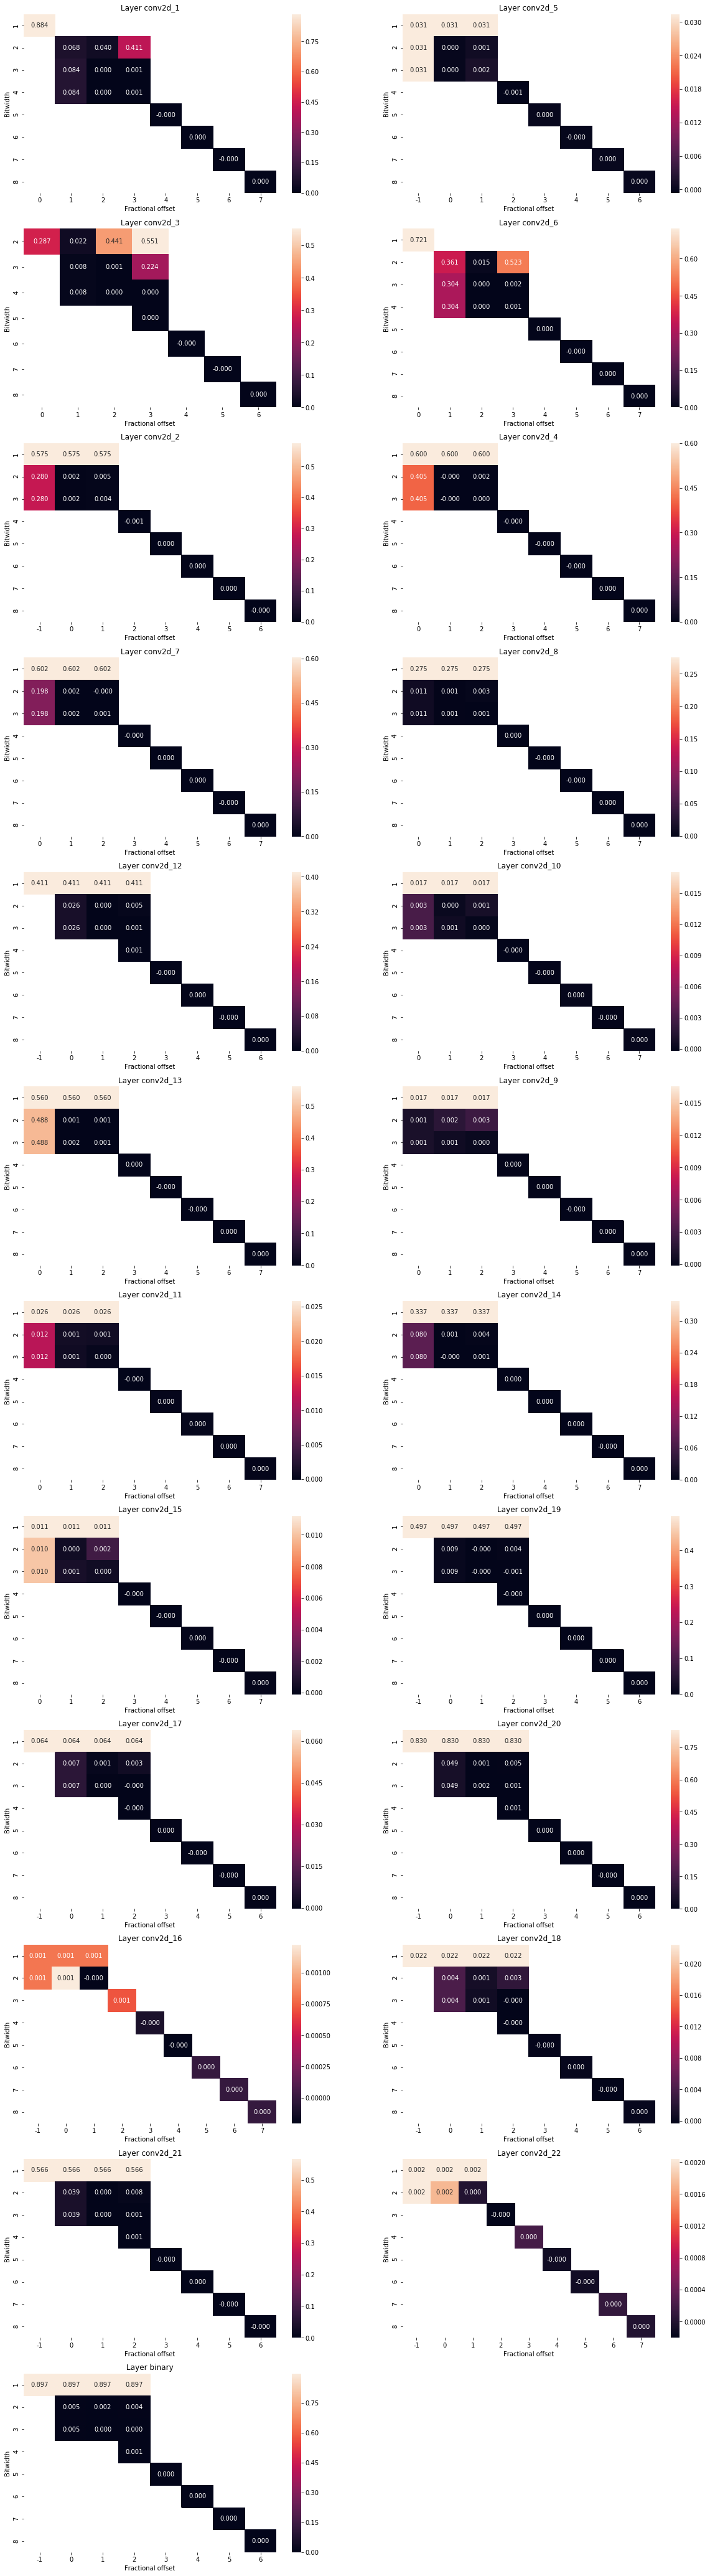

In [7]:
print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights)
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

opts.plot_scores_matrix(w_scores, 12, 2, (20, 75))

In [8]:
for layer in w_scores:
    print(layer)
    print(f'Layer {layer} acc drop: {w_scores[layer][opt_params_weights[layer][0]][opt_params_weights[layer][1]]:.5f}')

conv2d_1
Layer conv2d_1 acc drop: 0.00041
conv2d_5
Layer conv2d_5 acc drop: 0.00000
conv2d_3
Layer conv2d_3 acc drop: 0.00061
conv2d_6
Layer conv2d_6 acc drop: 0.00020
conv2d_2
Layer conv2d_2 acc drop: 0.00173
conv2d_4
Layer conv2d_4 acc drop: -0.00020
conv2d_7
Layer conv2d_7 acc drop: -0.00010
conv2d_8
Layer conv2d_8 acc drop: 0.00133
conv2d_12
Layer conv2d_12 acc drop: 0.00010
conv2d_10
Layer conv2d_10 acc drop: 0.00020
conv2d_13
Layer conv2d_13 acc drop: 0.00143
conv2d_9
Layer conv2d_9 acc drop: 0.00031
conv2d_11
Layer conv2d_11 acc drop: 0.00112
conv2d_14
Layer conv2d_14 acc drop: 0.00071
conv2d_15
Layer conv2d_15 acc drop: 0.00041
conv2d_19
Layer conv2d_19 acc drop: -0.00041
conv2d_17
Layer conv2d_17 acc drop: 0.00082
conv2d_20
Layer conv2d_20 acc drop: 0.00112
conv2d_16
Layer conv2d_16 acc drop: 0.00082
conv2d_18
Layer conv2d_18 acc drop: 0.00102
conv2d_21
Layer conv2d_21 acc drop: 0.00041
conv2d_22
Layer conv2d_22 acc drop: 0.00000
binary
Layer binary acc drop: 0.00184


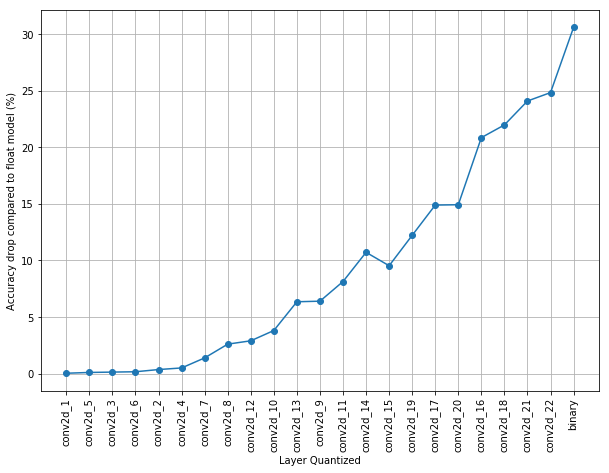

In [9]:
x = np.arange(1, len(acc_drop_w.values()) + 1, 1)
y = np.array(list(acc_drop_w.values())) * 100
labels = list(opt_params_weights.keys())

plt.figure(figsize=(10, 7))
plt.plot(x, y, 'o-');
plt.xlabel('Layer Quantized')
plt.ylabel('Accuracy drop compared to float model (%)')
plt.xticks(x, labels, rotation='vertical');
plt.grid()

## Biases

In [5]:
# biases
acc_drop_config = {
    layer_name: 0.003 for layer_name in layer_names
}
opts = IndependentOptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc, layer_independent_quant=True)
b_scores, opt_params_biases, acc_drop_b = opts.run('biases', start_bw = 8)
opt_params_biases

{'conv2d_1': [8, 9], 'conv2d_5': [8, 7], 'conv2d_3': [8, 7], 'conv2d_6': [8, 8], 'conv2d_2': [8, 8], 'conv2d_4': [8, 8], 'conv2d_7': [8, 8], 'conv2d_8': [8, 7], 'conv2d_12': [8, 7], 'conv2d_10': [8, 7], 'conv2d_13': [8, 7], 'conv2d_9': [8, 7], 'conv2d_11': [8, 8], 'conv2d_14': [8, 8], 'conv2d_15': [8, 7], 'conv2d_19': [8, 7], 'conv2d_17': [8, 7], 'conv2d_20': [8, 7], 'conv2d_16': [8, 8], 'conv2d_18': [8, 7], 'conv2d_21': [8, 7], 'conv2d_22': [8, 7], 'binary': [8, 9]}
Finding quantization for each layer independently of other layers
Quantizing layer conv2d_1
Global opt: (4, 5) Local opt: (5, 6) Performance diff: 0.000204
Chosen:  (4, 5)
After quantizing layer conv2d_1 | Measured accuracy drop 0.000816 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_5
Global opt: (1, 0) Local opt: (2, 1) Performance diff: 0.001122
Chosen:  (1, 0)
After quantizing layer conv2d_5 | Measured accuracy drop 0.019882 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_3
Global opt: (1, 0)

{'conv2d_1': (4, 5),
 'conv2d_5': (1, 0),
 'conv2d_3': (1, 0),
 'conv2d_6': (1, 0),
 'conv2d_2': (1, 0),
 'conv2d_4': (1, 1),
 'conv2d_7': (1, 1),
 'conv2d_8': (1, -1),
 'conv2d_12': (1, 0),
 'conv2d_10': (1, 0),
 'conv2d_13': (1, 0),
 'conv2d_9': (1, 0),
 'conv2d_11': (1, 0),
 'conv2d_14': (1, 1),
 'conv2d_15': (1, 0),
 'conv2d_19': (1, -1),
 'conv2d_17': (1, 0),
 'conv2d_20': (1, 0),
 'conv2d_16': (1, 1),
 'conv2d_18': (1, -1),
 'conv2d_21': (1, -1),
 'conv2d_22': (1, -1),
 'binary': (1, 1)}

Floating point model accuracy: 98.080 %
Quantized model accuracy: 89.970 %
Accuracy drop of 8.269 %


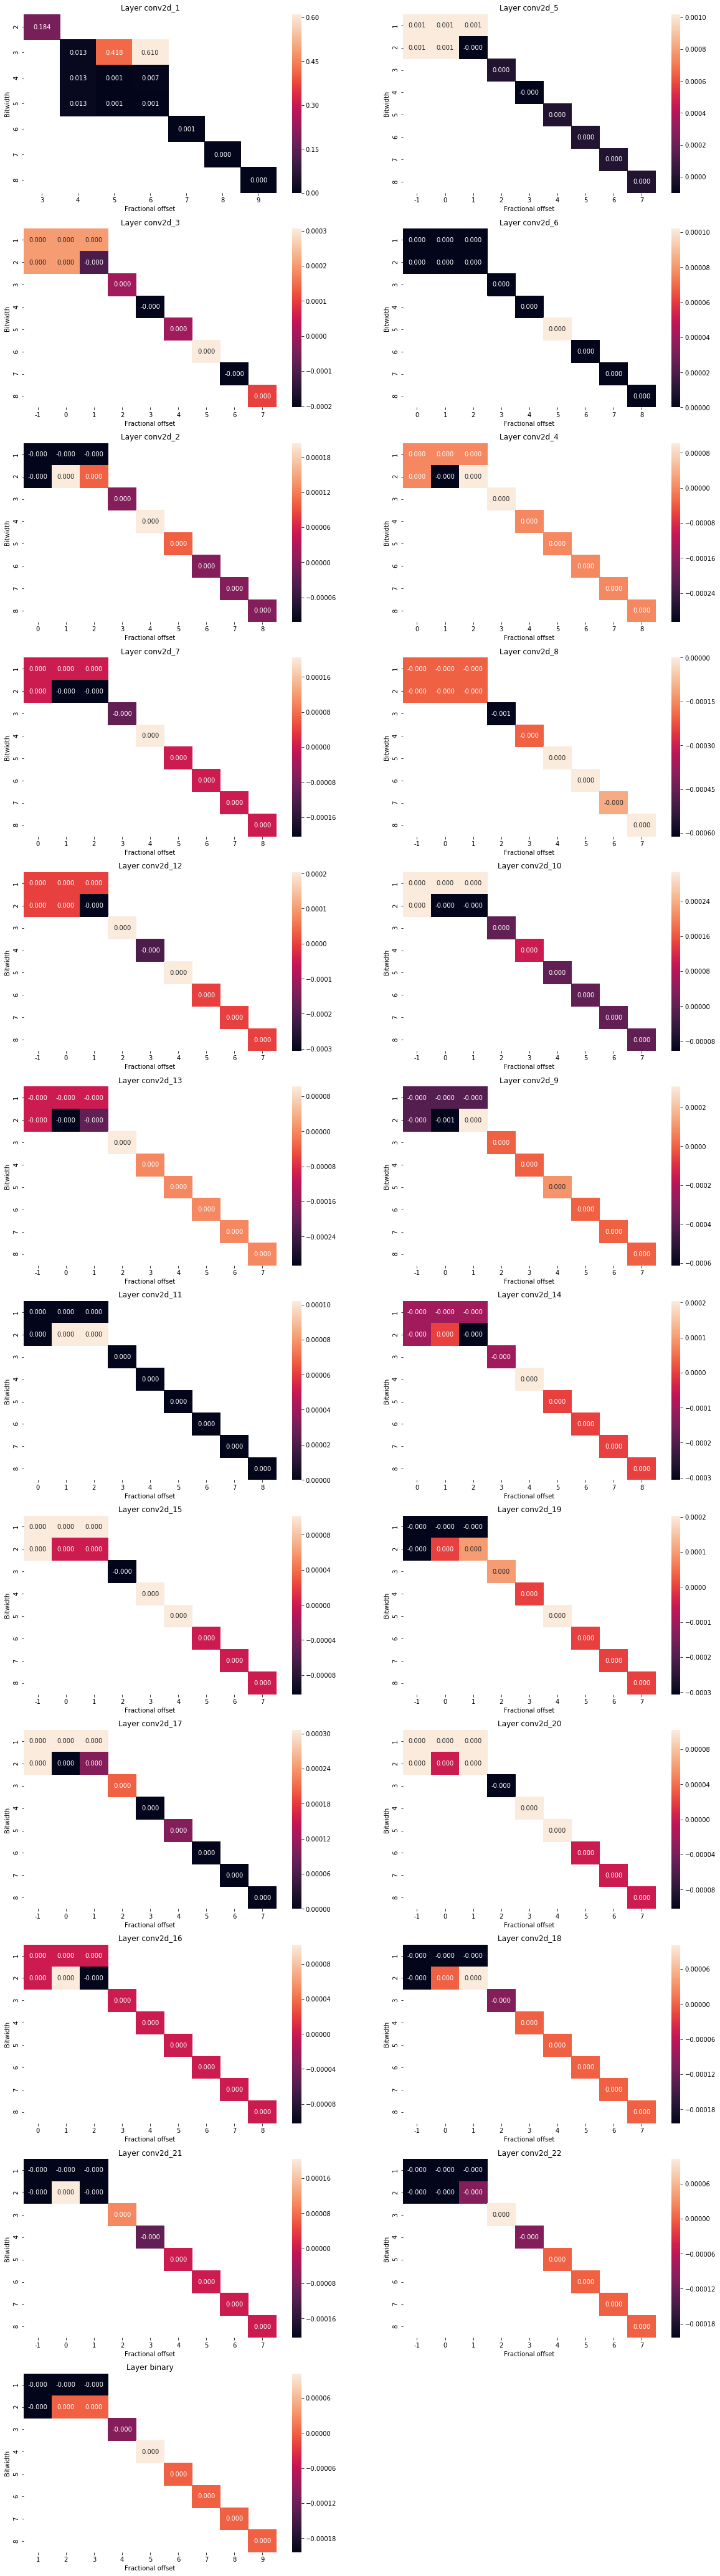

In [6]:
print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
model_obj = fxp_quantize.fix_biases_quantization(model_obj, opt_params_biases)
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

opts.plot_scores_matrix(b_scores, 12, 2, (20, 75))

In [7]:
for layer in b_scores:
    print(f'Layer {layer} acc drop: {b_scores[layer][opt_params_biases[layer][0]][opt_params_biases[layer][1]]:.5f}')

Layer conv2d_1 acc drop: 0.00082
Layer conv2d_5 acc drop: 0.00102
Layer conv2d_3 acc drop: 0.00020
Layer conv2d_6 acc drop: 0.00000
Layer conv2d_2 acc drop: -0.00010
Layer conv2d_4 acc drop: 0.00000
Layer conv2d_7 acc drop: 0.00000
Layer conv2d_8 acc drop: -0.00020
Layer conv2d_12 acc drop: 0.00000
Layer conv2d_10 acc drop: 0.00031
Layer conv2d_13 acc drop: -0.00010
Layer conv2d_9 acc drop: -0.00041
Layer conv2d_11 acc drop: 0.00000
Layer conv2d_14 acc drop: -0.00010
Layer conv2d_15 acc drop: 0.00010
Layer conv2d_19 acc drop: -0.00031
Layer conv2d_17 acc drop: 0.00031
Layer conv2d_20 acc drop: 0.00010
Layer conv2d_16 acc drop: 0.00000
Layer conv2d_18 acc drop: -0.00020
Layer conv2d_21 acc drop: -0.00020
Layer conv2d_22 acc drop: -0.00020
Layer binary acc drop: -0.00020


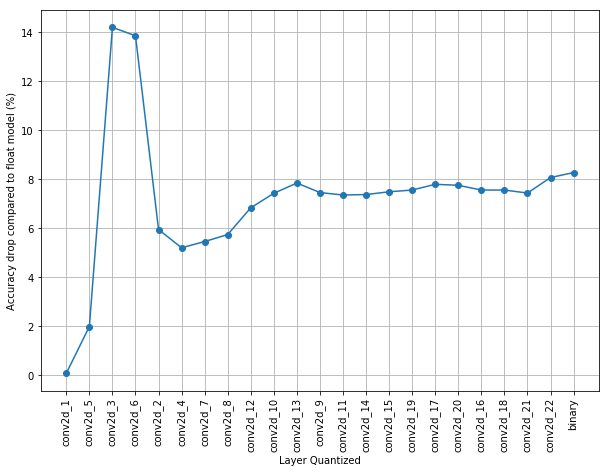

In [8]:
x = np.arange(1, len(acc_drop_b.values()) + 1, 1)
y = np.array(list(acc_drop_b.values())) * 100
labels = list(acc_drop_b.keys())

plt.figure(figsize=(10, 7))
plt.plot(x, y, 'o-');
plt.xlabel('Layer Quantized')
plt.ylabel('Accuracy drop compared to float model (%)')
plt.xticks(x, labels, rotation='vertical');
plt.grid()

### Activations

In [10]:
# weights
acc_drop_config = {
    layer_name: 0.003 for layer_name in layer_names
}
opts = IndependentOptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc, layer_independent_quant=True)
a_scores, opt_params_act, acc_drop_a = opts.run('activations', start_bw = 10)
opt_params_act

{'conv2d_1': [10, 8], 'conv2d_5': [10, 5], 'conv2d_3': [10, 5], 'conv2d_6': [10, 3], 'conv2d_2': [10, 5], 'conv2d_4': [10, 3], 'conv2d_7': [10, 3], 'conv2d_8': [10, 5], 'conv2d_12': [10, 4], 'conv2d_10': [10, 4], 'conv2d_13': [10, 2], 'conv2d_9': [10, 4], 'conv2d_11': [10, 2], 'conv2d_14': [10, 2], 'conv2d_15': [10, 4], 'conv2d_19': [10, 3], 'conv2d_17': [10, 3], 'conv2d_20': [10, 2], 'conv2d_16': [10, 3], 'conv2d_18': [10, 2], 'conv2d_21': [10, 2], 'conv2d_22': [10, 4], 'binary': [10, 3]}
Finding quantization for each layer independently of other layers
Quantizing layer conv2d_1
Global opt: (6, 5) Local opt: (7, 6) Performance diff: 0.001020
Chosen:  (6, 5)
After quantizing layer conv2d_1 | Measured accuracy drop 0.001122 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_5
Global opt: (2, -2) Local opt: (2, -2) Performance diff: 0.000000
Chosen:  (2, -2)
After quantizing layer conv2d_5 | Measured accuracy drop 0.002549 | Acceptable accuracy drop: 0.003000
Quantizing layer c

{'conv2d_1': (6, 5),
 'conv2d_5': (2, -2),
 'conv2d_3': (3, 0),
 'conv2d_6': (3, -3),
 'conv2d_2': (3, 0),
 'conv2d_4': (3, -2),
 'conv2d_7': (4, -1),
 'conv2d_8': (3, 1),
 'conv2d_12': (3, -2),
 'conv2d_10': (2, -3),
 'conv2d_13': (3, -3),
 'conv2d_9': (2, -3),
 'conv2d_11': (2, -4),
 'conv2d_14': (3, -3),
 'conv2d_15': (2, -3),
 'conv2d_19': (3, -3),
 'conv2d_17': (3, -2),
 'conv2d_20': (3, -4),
 'conv2d_16': (1, -6),
 'conv2d_18': (2, -5),
 'conv2d_21': (3, -4),
 'conv2d_22': (1, -5),
 'binary': (5, -1)}

In [11]:
with open(save_path + 'scores_a.p', 'wb') as f:
    pickle.dump(a_scores, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(save_path + 'opt_params_a.p', 'wb') as f:
    pickle.dump(opt_params_act, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(save_path + 'acc_drop_a.p', 'wb') as f:
    pickle.dump(acc_drop_a, f, protocol=pickle.HIGHEST_PROTOCOL)

Floating point model accuracy: 98.080 %
Quantized model accuracy: 83.930 %
Accuracy drop of 14.427 %


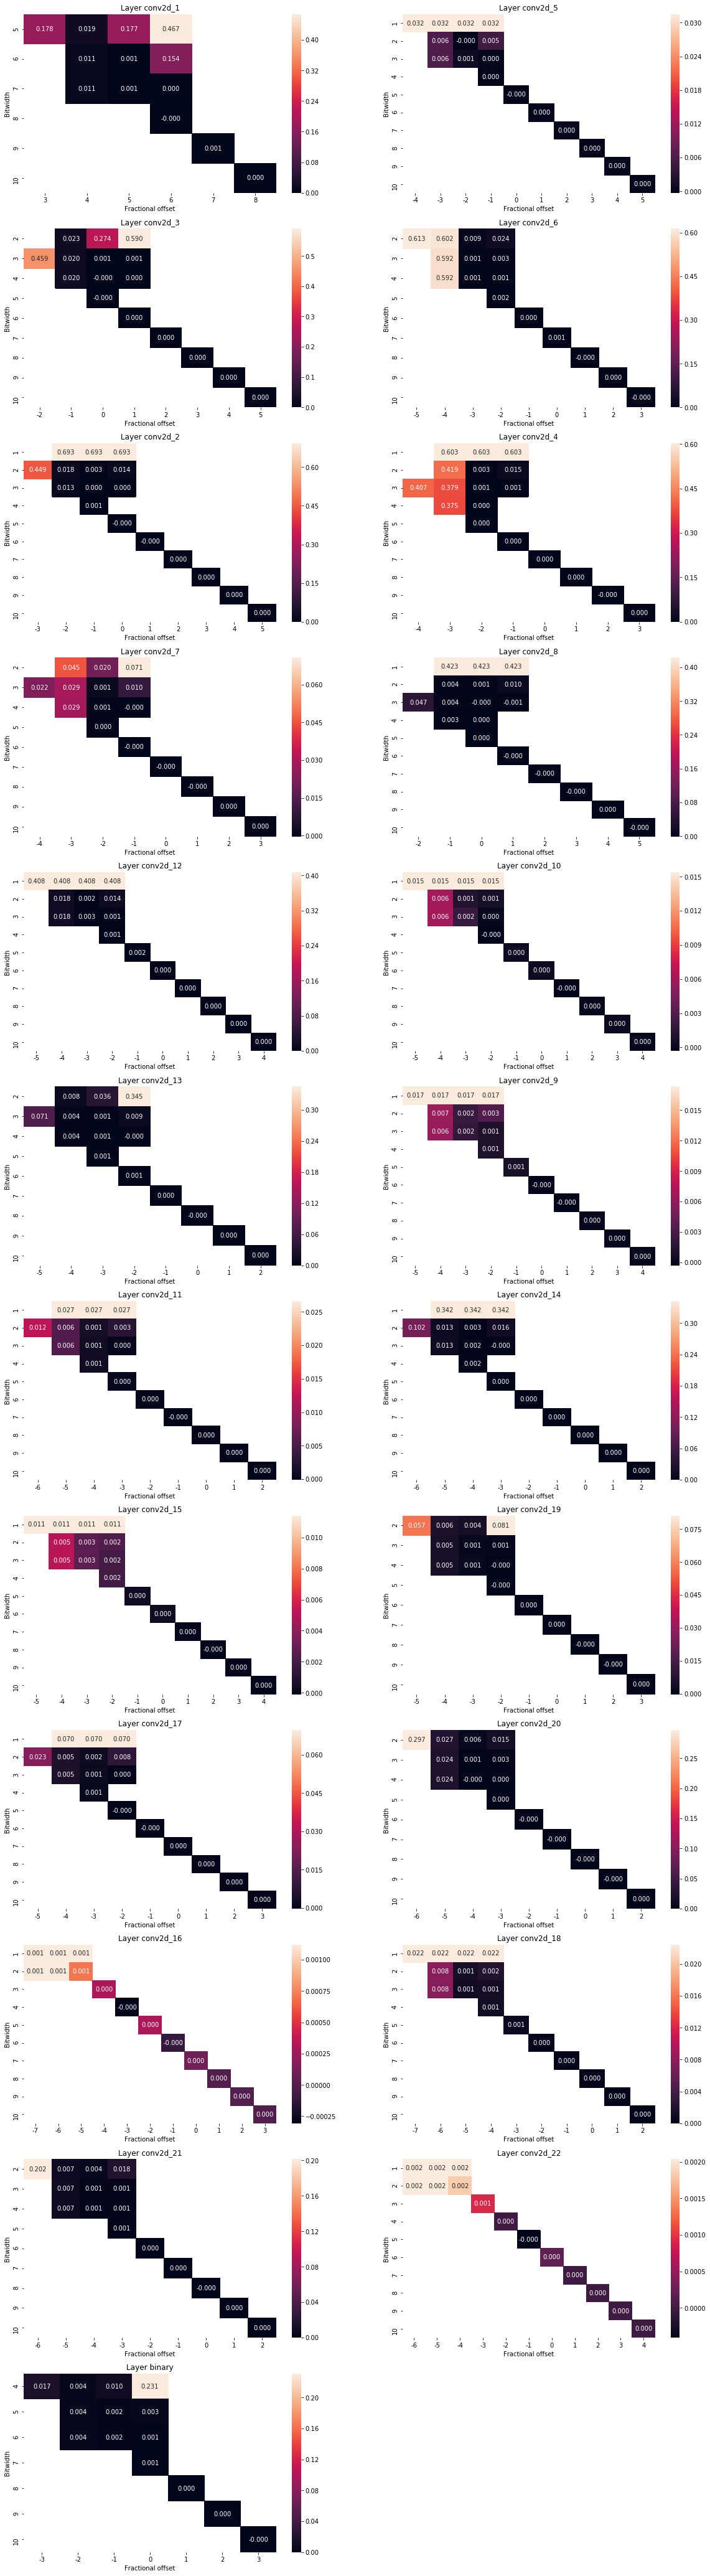

In [12]:
print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act))
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

opts.plot_scores_matrix(a_scores, 12, 2, (20, 75))

In [9]:
import pickle
save_path = 'C:/Users/320060820/experiments/outputs/Independent_Optimized_Search/DF MNIST/'

In [10]:
with open(save_path + 'opt_params_w.p', 'rb') as f:
    opt_params_weights = pickle.load(f)
with open(save_path + 'opt_params_a.p', 'rb') as f:
    opt_params_act = pickle.load(f)

In [11]:
def quantize_evaluate(model_arch, test_data, float_model_acc, w_quant_params, b_quant_params={}, a_quant_params={}):
    
    if a_quant_params:
        model_obj = model_data.Model('name', test_data, model=model_arch.get_fxp_model(a_quant_params))
    else:
        model_obj = model_data.Model('name', test_data, model=model_arch.get_float_model())
    
    model_obj = fxp_quantize.fix_weights_quantization(model_obj, w_quant_params)
    if b_quant_params:
        model_obj = fxp_quantize.fix_biases_quantization(model_obj, b_quant_params)
    
    return (float_model_acc - model_obj.evaluate_accuracy()[1]) / float_model_acc

def evaluate_seq_quant_performance(model_arch, test_data, float_model_acc, w_quant_params, b_quant_params, a_quant_params):
    
    acc_drop_b = {}
    for i in range(1, len(list(b_quant_params.keys())) + 1):
        test_case = dict(itertools.islice(b_quant_params.items(), i))
        a = quantize_evaluate(model_arch, test_data, float_model_acc, w_quant_params, test_case)
        acc_drop_b[list(test_case.keys())[-1]] = a
        print(acc_drop_b)

    acc_drop_a = {}
    for i in range(1, len(list(a_quant_params.keys())) + 1):
        test_case = dict(itertools.islice(a_quant_params.items(), i))
        a = quantize_evaluate(model_arch, test_data, float_model_acc, w_quant_params, b_quant_params, test_case)
        acc_drop_a[list(test_case.keys())[-1]] = a
        print(acc_drop_a)
        
    return acc_drop_b, acc_drop_a  

In [12]:
acc_drop_b, acc_drop_a = evaluate_seq_quant_performance(model_arch, test_data, float_model_acc, opt_params_weights, 
                                            opt_params_biases,
                                            opt_params_act)

{'conv2d_1': 0.45024469820554647}
{'conv2d_1': 0.45024469820554647, 'conv2d_5': 0.5999184339314846}
{'conv2d_1': 0.45024469820554647, 'conv2d_5': 0.5999184339314846, 'conv2d_3': 0.5779975530179445}
{'conv2d_1': 0.45024469820554647, 'conv2d_5': 0.5999184339314846, 'conv2d_3': 0.5779975530179445, 'conv2d_6': 0.5778955954323002}
{'conv2d_1': 0.45024469820554647, 'conv2d_5': 0.5999184339314846, 'conv2d_3': 0.5779975530179445, 'conv2d_6': 0.5778955954323002, 'conv2d_2': 0.6853588907014682}
{'conv2d_1': 0.45024469820554647, 'conv2d_5': 0.5999184339314846, 'conv2d_3': 0.5779975530179445, 'conv2d_6': 0.5778955954323002, 'conv2d_2': 0.6853588907014682, 'conv2d_4': 0.6791394779771616}
{'conv2d_1': 0.45024469820554647, 'conv2d_5': 0.5999184339314846, 'conv2d_3': 0.5779975530179445, 'conv2d_6': 0.5778955954323002, 'conv2d_2': 0.6853588907014682, 'conv2d_4': 0.6791394779771616, 'conv2d_7': 0.6794453507340946}
{'conv2d_1': 0.45024469820554647, 'conv2d_5': 0.5999184339314846, 'conv2d_3': 0.5779975530

{'conv2d_1': 0.45024469820554647, 'conv2d_5': 0.5999184339314846, 'conv2d_3': 0.5779975530179445, 'conv2d_6': 0.5778955954323002, 'conv2d_2': 0.6853588907014682, 'conv2d_4': 0.6791394779771616, 'conv2d_7': 0.6794453507340946, 'conv2d_8': 0.7106443719412725, 'conv2d_12': 0.7085032626427407, 'conv2d_10': 0.7067699836867863, 'conv2d_13': 0.7094208809135399, 'conv2d_9': 0.7049347471451877, 'conv2d_11': 0.7029975530179445, 'conv2d_14': 0.7014681892332789, 'conv2d_15': 0.6978996737357259, 'conv2d_19': 0.6909665579119086, 'conv2d_17': 0.7010603588907015, 'conv2d_20': 0.7018760195758564, 'conv2d_16': 0.7002446982055466, 'conv2d_18': 0.7041190864600326, 'conv2d_21': 0.7035073409461663, 'conv2d_22': 0.717373572593801, 'binary': 0.7244086460032627}
{'conv2d_1': 0.7838499184339315}
{'conv2d_1': 0.7838499184339315, 'conv2d_5': 0.6682300163132137}
{'conv2d_1': 0.7838499184339315, 'conv2d_5': 0.6682300163132137, 'conv2d_3': 0.6941272430668842}
{'conv2d_1': 0.7838499184339315, 'conv2d_5': 0.6682300163

{'conv2d_1': 0.7838499184339315, 'conv2d_5': 0.6682300163132137, 'conv2d_3': 0.6941272430668842, 'conv2d_6': 0.6488580750407831, 'conv2d_2': 0.7676386623164764, 'conv2d_4': 0.7949632952691681, 'conv2d_7': 0.8155587275693312, 'conv2d_8': 0.8463499184339316, 'conv2d_12': 0.8063825448613376, 'conv2d_10': 0.769473898858075, 'conv2d_13': 0.7657014681892332, 'conv2d_9': 0.7114600326264274, 'conv2d_11': 0.7478588907014683, 'conv2d_14': 0.7321574225122348, 'conv2d_15': 0.7091150081566069, 'conv2d_19': 0.7556076672104405, 'conv2d_17': 0.7248164763458402, 'conv2d_20': 0.6890293637846655, 'conv2d_16': 0.6890293637846655, 'conv2d_18': 0.7204323001631321, 'conv2d_21': 0.7561174551386624, 'conv2d_22': 0.7431688417618271}
{'conv2d_1': 0.7838499184339315, 'conv2d_5': 0.6682300163132137, 'conv2d_3': 0.6941272430668842, 'conv2d_6': 0.6488580750407831, 'conv2d_2': 0.7676386623164764, 'conv2d_4': 0.7949632952691681, 'conv2d_7': 0.8155587275693312, 'conv2d_8': 0.8463499184339316, 'conv2d_12': 0.80638254486

In [13]:
with open(save_path + 'scores_b.p', 'wb') as f:
    pickle.dump(b_scores, f)
with open(save_path + 'opt_params_b.p', 'wb') as f:
    pickle.dump(opt_params_biases, f)
with open(save_path + 'acc_drop_b.p', 'wb') as f:
    pickle.dump(acc_drop_b, f)

with open(save_path + 'acc_drop_a.p', 'wb') as f:
    pickle.dump(acc_drop_a, f)